#Project2 - Seoul Bike Trip Duration - Prediction

#### **1) Import Libraries**

In [1]:
# Read Data
import numpy as np                     # Linear Algebra (calculate the mean and standard deviation)
import pandas as pd                    # manipulate data, data processing, load csv file I/O (e.g. pd.read_csv)

# Visualization
import seaborn as sns                  # Visualization using seaborn
import matplotlib.pyplot as plt        # Visualization using matplotlib
%matplotlib inline

# style
plt.style.use("fivethirtyeight")       # Set Graphs Background style using matplotlib
sns.set_style("darkgrid")              # Set Graphs Background style using seaborn

import warnings                        # Ignore Warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor, plot_importance

from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,cohen_kappa_score

#### **2) Import Data**

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
bike = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML Project/Seoul_Bike_Trip_Duration/For_modeling.csv')

#Preprocessing

Missing values
- Dropping **0** entries in **Trip duration and Trip distance** is the first step.

In [5]:
bike.isnull().sum()


Unnamed: 0    0
Duration      0
Distance      0
PLong         0
PLatd         0
DLong         0
DLatd         0
Haversine     0
Pmonth        0
Pday          0
Phour         0
Pmin          0
PDweek        0
Dmonth        0
Dday          0
Dhour         0
Dmin          0
DDweek        0
Temp          0
Precip        0
Wind          0
Humid         0
Solar         0
Snow          0
GroundTemp    0
Dust          0
dtype: int64

In [6]:
bike_original=bike.copy()

In [7]:
Corr=pd.DataFrame(bike.corr().unstack().sort_values(ascending=False)['Duration'],columns=['Correlation to the target'])
Corr.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

,Correlation to the target
Duration,1.000000
Distance,0.739233
Haversine,0.352915
Dhour,0.140381
Phour,0.133392
Temp,0.128204
GroundTemp,0.120210
DDweek,0.081320
PDweek,0.080753
Wind,0.072325


In [8]:
bike.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
df = bike.drop(['PLatd', 'DLatd', 'Pday', 'Pmin', 'Dday', 'Dmin', 'Precip', 'Snow', 'Dust'], axis=1)
df.head()

,Duration,Distance,PLong,DLong,Haversine,Pmonth,Phour,PDweek,Dmonth,Dhour,DDweek,Temp,Wind,Humid,Solar,GroundTemp
0,3,50,37.544666,37.544666,0.000000,1,0,0,1,0,0,-3.2,0.5,40.0,0.0,-2.2
1,24,7670,37.506199,37.551250,5.713529,1,0,0,1,0,0,-3.2,0.5,40.0,0.0,-2.2
2,8,1390,37.544590,37.537014,0.913702,1,0,0,1,0,0,-3.2,0.5,40.0,0.0,-2.2
3,8,1820,37.571102,37.561447,1.468027,1,0,0,1,0,0,-3.2,0.5,40.0,0.0,-2.2
4,4,850,37.573242,37.565849,0.823227,1,0,0,1,0,0,-3.2,0.5,40.0,0.0,-2.2


Duplicate rows

In [10]:
bike.duplicated().value_counts()

False    9577233
True       23906
dtype: int64

In [11]:
# Remove all duplicates
bike.drop_duplicates(inplace=True)
print("Dataset size before removing duplicates:", bike_original.shape)
print("Dataset size after removing duplicates:", bike.shape)

Dataset size before removing duplicates: (9601139, 26)
Dataset size after removing duplicates: (9577233, 25)


In [12]:
df.duplicated().value_counts()

False    9564712
True       36427
dtype: int64

In [13]:
# Remove all duplicates
df.drop_duplicates(inplace=True)
print("Dataset size before removing duplicates:", bike_original.shape)
print("Dataset size after removing duplicates:", df.shape)

Dataset size before removing duplicates: (9601139, 26)
Dataset size after removing duplicates: (9564712, 16)


In [14]:
df.head()

,Duration,Distance,PLong,DLong,Haversine,Pmonth,Phour,PDweek,Dmonth,Dhour,DDweek,Temp,Wind,Humid,Solar,GroundTemp
0,3,50,37.544666,37.544666,0.000000,1,0,0,1,0,0,-3.2,0.5,40.0,0.0,-2.2
1,24,7670,37.506199,37.551250,5.713529,1,0,0,1,0,0,-3.2,0.5,40.0,0.0,-2.2
2,8,1390,37.544590,37.537014,0.913702,1,0,0,1,0,0,-3.2,0.5,40.0,0.0,-2.2
3,8,1820,37.571102,37.561447,1.468027,1,0,0,1,0,0,-3.2,0.5,40.0,0.0,-2.2
4,4,850,37.573242,37.565849,0.823227,1,0,0,1,0,0,-3.2,0.5,40.0,0.0,-2.2


In [15]:
bike.shape

(9577233, 25)

- Create some additional features from the date/time variable to make the machine learning algorithms work more efficiently. 
- This process of creating additional features from the existing data by using domain knowledge is known as feature engineering.

- From the Pickup date and time variable, variables such as pickup month, day, hour, minute and day of the week are computed.
- From Dropoff date and time variable, variables such as dropoff month, day, hour, minute and day of the week are extracted.
- Although the trip distance is already present in the data, the distance between pickup station and drop off station is computed using haversine function, by using pickup latitude and longitude details and drop off latitude and longitude details.

#Modelling

In [16]:
df = df.iloc[0:900000, 0:16]

In [17]:
df.head()

,Duration,Distance,PLong,DLong,Haversine,Pmonth,Phour,PDweek,Dmonth,Dhour,DDweek,Temp,Wind,Humid,Solar,GroundTemp
0,3,50,37.544666,37.544666,0.000000,1,0,0,1,0,0,-3.2,0.5,40.0,0.0,-2.2
1,24,7670,37.506199,37.551250,5.713529,1,0,0,1,0,0,-3.2,0.5,40.0,0.0,-2.2
2,8,1390,37.544590,37.537014,0.913702,1,0,0,1,0,0,-3.2,0.5,40.0,0.0,-2.2
3,8,1820,37.571102,37.561447,1.468027,1,0,0,1,0,0,-3.2,0.5,40.0,0.0,-2.2
4,4,850,37.573242,37.565849,0.823227,1,0,0,1,0,0,-3.2,0.5,40.0,0.0,-2.2


In [18]:
feature_columns = ['Distance', 'PLong', 'DLong', 'Haversine', 'Pmonth', 'Phour', 'PDweek', 'Dmonth', 'Dhour', 'DDweek', 'Temp', 'Wind', 'Humid', 'Solar', 'GroundTemp']

In [19]:
reporting={}

In [20]:
X = df.drop(['Duration'],axis=1)
y = df['Duration']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### **7) Model Evaluation**

##### **7.1) Random Forest**

In [22]:
rfc = RandomForestRegressor()
rfc.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [23]:
y_pred_rfc = rfc.predict(X_test)

In [24]:
print("Random Forest : Train Score {:.2f} & Test Score {:.2f}".format(rfc.score(X_train, y_train), rfc.score(X_test, y_test)))

Random Forest : Train Score 0.97 & Test Score 0.80


No handles with labels found to put in legend.


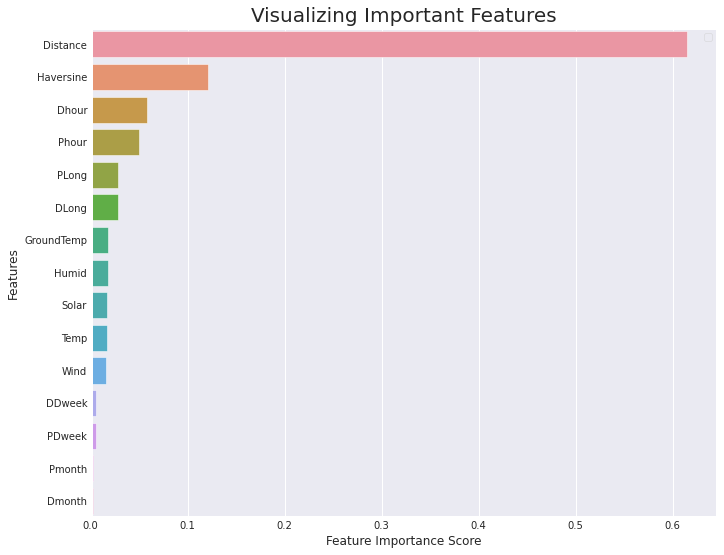

In [25]:
plt.figure(figsize=(10,9))
feature_imp = pd.Series(rfc.feature_importances_, index=X.columns).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", size=20)
plt.legend()
plt.show()

### ##### **7.2) XGBoost**

In [26]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

[14:18:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [27]:
# make predictions for test set
y_pred_xgb = xgb.predict(X_test)
predictions = [round(value) for value in y_pred_xgb]

In [28]:
print("XGBoost : Train Score {:.2f} & Test Score {:.2f}".format(xgb.score(X_train, y_train), xgb.score(X_test, y_test)))

XGBoost : Train Score 0.75 & Test Score 0.75


No handles with labels found to put in legend.


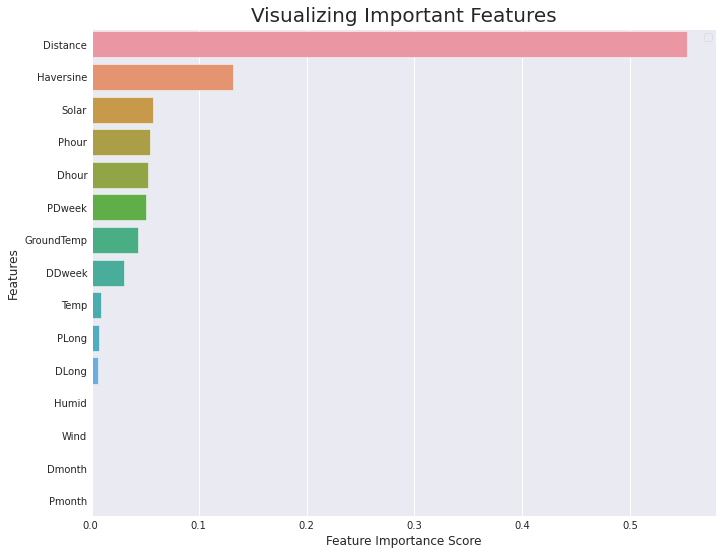

In [29]:
plt.figure(figsize=(10,9))
feature_imp = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", size=20)
plt.legend()
plt.show()

**7.3) LGBM**

In [30]:
LGB = LGBMRegressor()
LGB.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [31]:
y_pred_LGB = LGB.predict(X_test)

In [32]:
print("LGBM : Train Score {:.2f} & Test Score {:.2f}".format(LGB.score(X_train, y_train), LGB.score(X_test, y_test)))

LGBM : Train Score 0.82 & Test Score 0.82


In [33]:
mae_lgb = mean_absolute_error(y_test, y_pred_LGB)
print("MAE: ", mae_lgb)

MAE:  6.0856761289843115


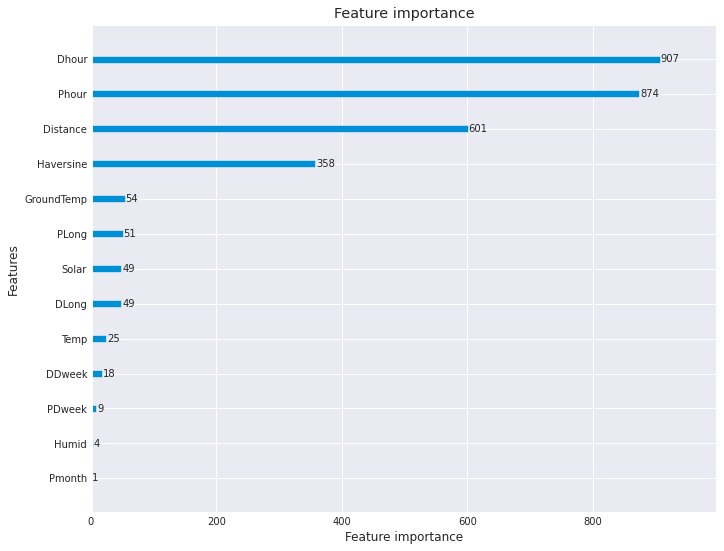

In [34]:
plot_importance(LGB, figsize=(10, 9));

#### **Saving Files**

In [35]:
import joblib

with open("model.joblib", 'wb') as model:
    joblib.dump(LGB, model, compress=1)

In [36]:
with open("features.joblib", 'wb') as ft:
    joblib.dump(feature_columns, ft, compress=1)

#### **8) Model Explainability (Explainable AI)**

##### **SHAP(Shapley Additive Explanations)**

In [37]:
!pip install shap

     |████████████████████████████████| 356 kB 14.5 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491650 sha256=ca893acf61b95bfdd2fda52965e7d1f71517a3bdb5c085106380f334cf5d994e
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [38]:
import shap
shap.initjs()

In [39]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(LGB)
# Calculate Shap values
shap_values = explainer.shap_values(X_test)

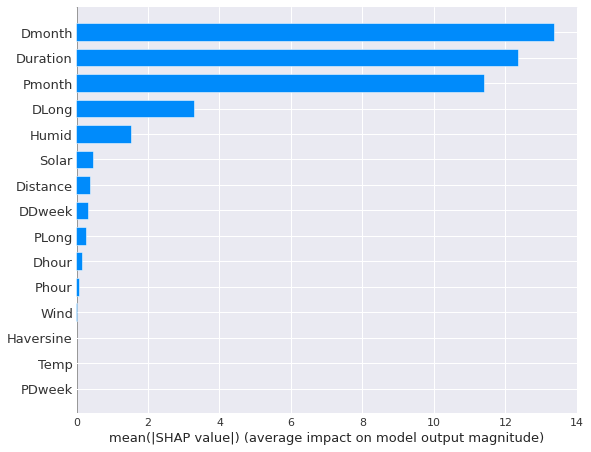

In [40]:
# SHAP Feature importance
shap.summary_plot(shap_values, X_train, feature_names=df.columns, plot_type="bar")

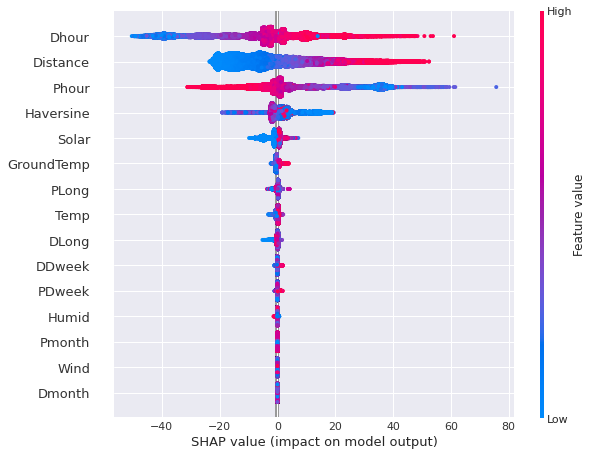

In [41]:
shap.summary_plot(shap_values, X_test)

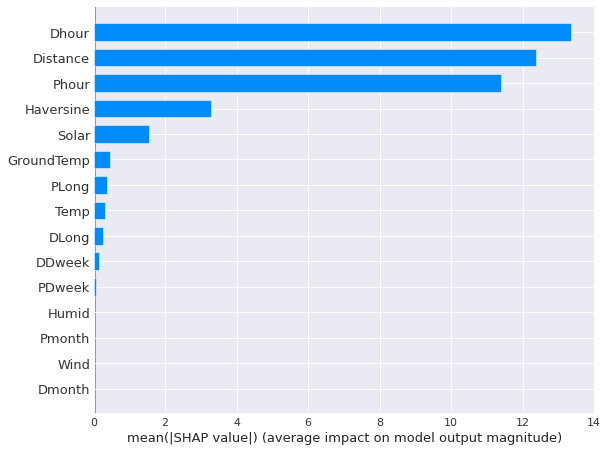

In [42]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### **SHAP Dependence Plots**

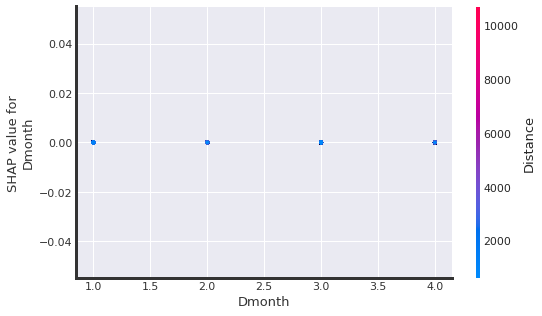

In [43]:
shap.dependence_plot("Dmonth", shap_values, X_test)